In [913]:
# libraries needed
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import cm 
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import SCORERS


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics as m
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [914]:
df = pd.read_csv("winequality-red.csv")

#### 1. Visualize and analyze the data

In [915]:
df.isna().sum() # no nan values ✔

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [916]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000
mean,8.314160,0.527954,0.270276,2.535558,0.087120,15.858396,46.382206,0.996744,3.311917,0.656385,10.421147,5.637218
std,1.732203,0.179176,0.193894,1.405515,0.045251,10.460554,32.839138,0.001888,0.153346,0.163057,1.060371,0.807080
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996745,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997832,3.400000,0.730000,11.100000,6.000000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.000000,8.000000


In [917]:
# a mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
# you can use the map function of pandas with any dictionary 
# to convert the values in a given column to values in the dictionary

df["quality"] = df["quality"].map(quality_mapping)

##### Feature Engineering:
Lets generate some extra-variables based on the available ones

In [918]:
# df["acidity_by_Ph"] = df["fixed acidity"]/df["pH"]
df["density_sugar"] = df["density"]/df["residual sugar"]
df["sulphate_by_chloride"] = df["sulphates"]/df["chlorides"]

In [919]:
df.drop("sulphates", axis=1, inplace=True) # we will incorporate sulphate_by_chloride which correlates better

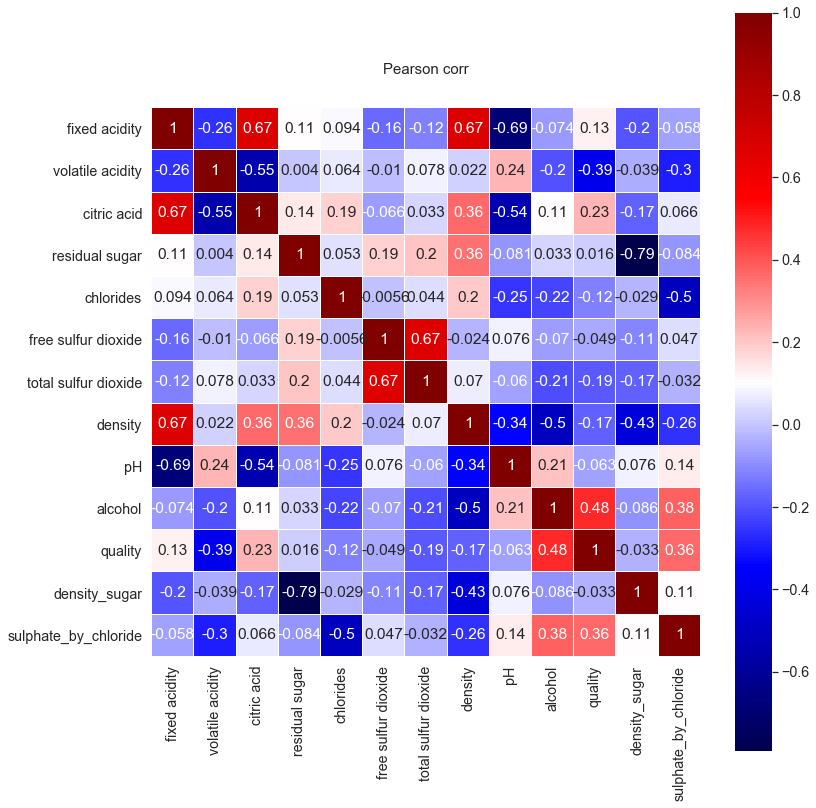

In [968]:
plt.rcParams["figure.figsize"] = (12,12)
colormap=plt.cm.seismic
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
# plt.savefig("corr.png", dpi=400)
plt.tight_layout()
plt.show()

In [921]:
corr_matrix = df.corr()
corr_vals = abs(corr_matrix["quality"]).sort_values(ascending=False)
top8_corr =  corr_vals[1:9]

In [922]:
top8_corr # we will carry with these attributes for the modeling

alcohol                 0.480738
volatile acidity        0.391735
sulphate_by_chloride    0.363317
citric acid             0.233733
total sulfur dioxide    0.185404
density                 0.173251
fixed acidity           0.127766
chlorides               0.119770
Name: quality, dtype: float64

In [923]:
top8_corr = pd.DataFrame(top8_corr)

We observe that the atributes that correlate best with the wine quality are alcohol, volatile acicity, sulphates, citric acid, total sufur dioxide, density, fixed acidity and chlorides. We will be using these in the modeling

In [924]:
list_top8 = list(top8_corr.index)

In [925]:
list_top8.append("quality")

In [926]:
df_model = df[list_top8]

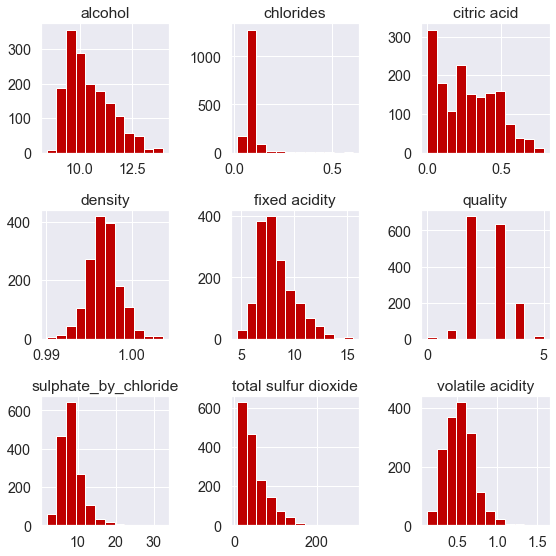

In [969]:
plt.rcParams["figure.figsize"] = (8,8)
df_model.hist(bins=12, color=gist_heat(random.uniform(0, 1)))
plt.tight_layout()
plt.show()

We can see that most of the selected attributes shown an skewed distribution and possess different scales. We will therefore standarized the data before modeling. But first, lets split the data into the test and train sets.

#### 2. Splitting data: 
First we check the distribution of the target values to see if an stratified split is needed

Text(0, 0.5, 'count')

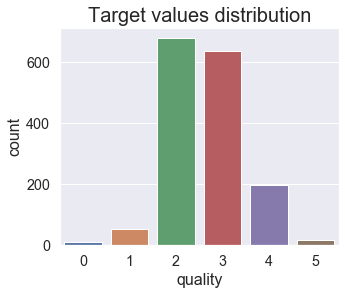

In [928]:
plt.rcParams["figure.figsize"] = (5,4)
ax = sns.countplot(x='quality', data=df)
ax.set_title("Target values distribution", fontsize=20)
ax.set_xlabel("quality", fontsize=16)
ax.set_ylabel("count", fontsize=16)
# plt.savefig("target_values_distribution.png", dpi=400)


We can see that we have a skewed dataset for classification 
so we may want to stratify the data before split. Furthermore, we will want to use **stratified k-fold cross-validation** (For classification problems).

-> There are several choices for selecting the appropriate number of bins. If
you have a lot of samples( > 10k, > 100k), then you don’t need to care about the
number of bins. Just divide the data into 10 or 20 bins. If you do not have a lot of
samples, you can use a simple rule like Sturge’s Rule to calculate the appropriate
number of bins.


Number of Bins = 1 + log2(N) Where N is the number of samples you have in your dataset. # 12 in our case

For the stratification we will use the most correlated attribute (alchohol)

In [929]:
def strater (col_item):
    if col_item <= 9.3:
        return 1
    elif col_item > 9.3 and col_item <= 10:
        return 2
    elif col_item > 10 and col_item <= 11:
        return 3
    elif col_item > 11 and col_item <= 12:
        return 4
    else:
        return 5

In [930]:
df_model["strat"] = df_model["alcohol"].apply(strater)

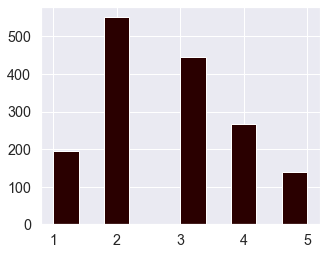

In [931]:
df_model["strat"].hist(color=gist_heat(random.uniform(0, 1)))

In [932]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=10)

In [933]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [934]:
# we will also do a random split tocompare the results of the distribution
X = df_model.drop("quality", axis=1)
y = df_model["quality"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # 0.2 means 80 % is in our train set and 20

In [935]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [936]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [937]:
comparing = comparing *100 

In [938]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

,Overall,Stratified,Random
1,12.155388,12.1875,11.8750
2,34.523810,34.3750,33.4375
3,27.819549,27.8125,27.1875
4,16.729323,16.8750,17.5000
5,8.771930,8.7500,10.0000


In [939]:
df_model.drop("strat", axis=1, inplace=True)

In [940]:
X = df_model.drop("quality", axis=1)

we go with stratified split then:

In [941]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [942]:
X_train = strat_train_set.drop("quality", axis=1)
y_train = strat_train_set["quality"].values

In [943]:
X_test = strat_test_set.drop("quality", axis=1)
y_test = strat_test_set["quality"].values

#### 3. Standarization of the data
Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units.

<!-- Standarization implies that the features will be rescaled to ensure the mean and the standard deviation to be 0 and 1, respectively. -->

In [944]:
scaler = StandardScaler().fit(X_train)
X_train_rescaled = scaler.transform(X_train)

In [945]:
df_rescaled = pd.DataFrame(X_train_rescaled, columns=df_model.columns[:-1])

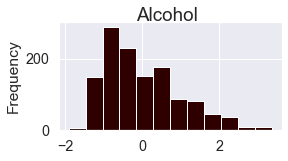

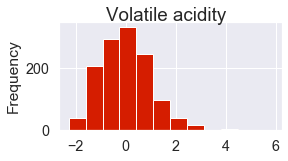

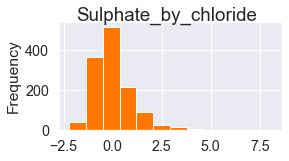

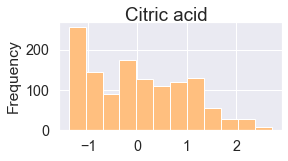

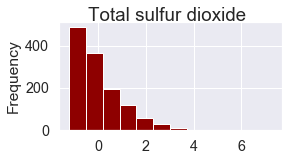

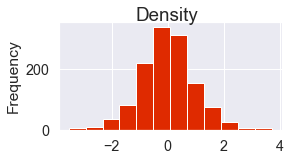

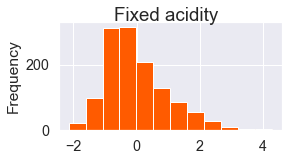

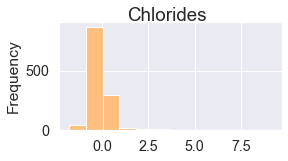

In [970]:
gist_heat = cm.get_cmap('gist_heat', 200)
for i in top8_corr.index:
    df_rescaled[i].plot(kind="hist", bins=12,
               subplots=True,
               figsize=(4,2), 
               title=str.capitalize(i),
               color=gist_heat(random.uniform(0, 1)))
    plt.show()

#### 4. Exploring model performance

**What performance metric should we use?**  It depends on the purpose of our model but for this case scenario we may want a balanced model with acceptable precision as well as recall. Hence, f1_score may be prefered. Furthermore, since the distribution of our targets is imbalanced, we may want to use micro-averages which aggregates the contributions of all classes to compute the average metric. Macro-average on the other side would treat all classes equally and would be preferred in a balanced class distribution scenario.

In [947]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [948]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier())) 
models.append(('GNB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('SVC', SVC()))

results_model = []
names_model = []
for name, model in models:
    SKF = StratifiedKFold(n_splits=12, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled, y_train, cv=SKF, scoring='f1_micro')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.592466 (0.044876)
SGD: 0.535245 (0.044902)
GNB: 0.542276 (0.037442)
CART: 0.588491 (0.039607)
KNC: 0.580725 (0.045412)
SVC: 0.607366 (0.036009)


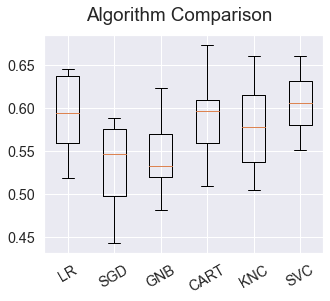

In [949]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_model)
ax.set_xticklabels(names_model, rotation=30)
plt.show()
# plt.savefig("algo_comparison.png", dpi=400)


#### 5. Fine tune SVC

In [950]:
kernel = ["rbf"] # ["linear", "poly", "rbf", "sigmoid"] 
C = [0.1, 0.5, 1.5, 2.5, 8.5]

param_grid = dict(kernel=kernel, C=C)


model = SVC()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best 0.623832 (0.038673) using {'C': 1.5, 'kernel': 'rbf'}

Best: 0.608138 using {'C': 1.5, 'kernel': 'rbf'}
0.579858 (0.042108) with: {'C': 0.1, 'kernel': 'rbf'}
0.597161 (0.029608) with: {'C': 0.5, 'kernel': 'rbf'}
0.608138 (0.042067) with: {'C': 1.5, 'kernel': 'rbf'}
0.603421 (0.045999) with: {'C': 2.5, 'kernel': 'rbf'}
0.600298 (0.040984) with: {'C': 8.5, 'kernel': 'rbf'}


In [951]:
SVC_rbf = SVC(kernel="rbf", C=1.5)
SVC_rbf.fit(X_train_rescaled, y_train)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### 6. Evaluating the model

In [952]:
scaler = StandardScaler().fit(X_test)
X_test_rescaled = scaler.transform(X_test)

In [953]:
SVC_rbf.score(X_train_rescaled,y_train)

0.6637931034482759

In [954]:
SVC_rbf.score(X_test_rescaled,y_test)

0.609375

In [955]:
y_preds = SVC_rbf.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))


F1_score:

0.609375
Confusion Matrix:

[[  0   0   2   0   0   0]
 [  0   0   4   2   0   0]
 [  0   0 107  40   1   0]
 [  0   0  38  78   9   0]
 [  0   0   2  23  10   0]
 [  0   0   0   3   1   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.70      0.72      0.71       148
           3       0.53      0.62      0.58       125
           4       0.48      0.29      0.36        35
           5       0.00      0.00      0.00         4

    accuracy                           0.61       320
   macro avg       0.28      0.27      0.27       320
weighted avg       0.58      0.61      0.59       320



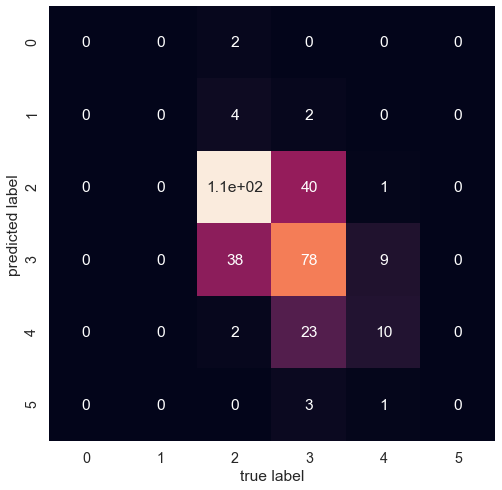

In [956]:
# Import Seaborn
sns.set(font_scale=1.3) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

We see that we hit a 61% of predictions correcly, and as we can appreciate in the confusion matrix, most of errors fall by one point of quality(+-1), meaning that we can make good use of our model to estimate the quality of red wine.
We also observe more false negatives (below the diagonal) than false positives (above the diagonal) meaning that our **precision** is better than our **recall**. Or in other words, our model is more **specific** than **sensitive**.

ROC Curve (plot of true positive rate versus false positive rate) and AUC (Area Under Curve) Scores¶
[see](https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification)

We have to convert your problem into binary by using OneVsAll approach, so we will end-up with n_class number of ROC curves

In [957]:
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5])
n_classes = 6

In [958]:
y_score = SVC_rbf.fit(X_train_rescaled, y_train).decision_function(X_test_rescaled)

In [959]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

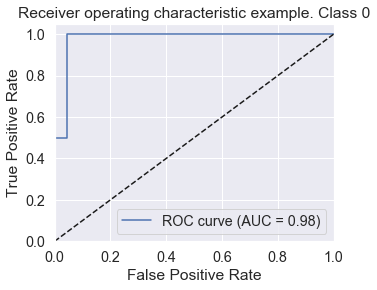

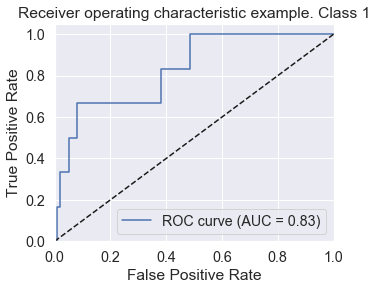

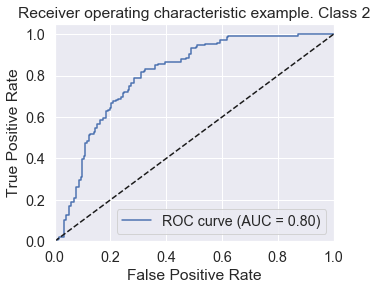

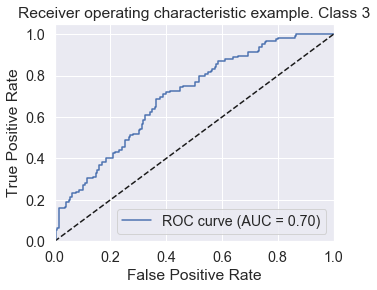

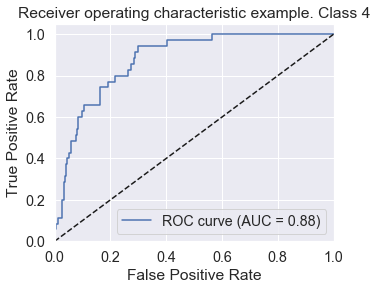

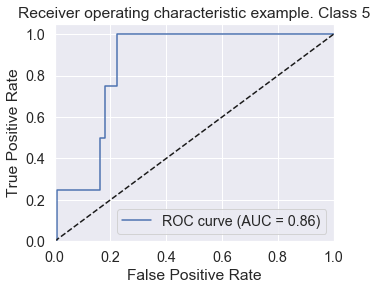

In [960]:
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example. Class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

For instance, we can observe that we have good room for improvement predicting the classes 2 and 3. It appears that the model produced struggles more with the middle values, which was to be be expected

Another important aspect of the model functioning is **feature
importance**. We can use an attibute called coef_ to stimate feature importance in SVC models, but the kernel needs to be linear. Lets train a SVC with kernel linear to get idea about the feature importance in this type of model:

In [961]:
SVC_linear = SVC(kernel="linear", C=1.5)
SVC_linear.fit(X_train_rescaled, y_train)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [962]:
features_dict = dict(zip(top8_corr.index, list(SVC_linear.coef_[0])))
features_imp_df = pd.DataFrame(features_dict, index=["feature_importance"]).T

In [963]:
top8_corr.columns = ["feature_corr"]

In [964]:
features_df = pd.concat([top8_corr, features_imp_df], axis=1)

In [965]:
features_df

,feature_corr,feature_importance
alcohol,0.480738,-0.241646
volatile acidity,0.391735,0.468525
sulphate_by_chloride,0.363317,0.217496
citric acid,0.233733,0.079163
total sulfur dioxide,0.185404,-0.574641
density,0.173251,0.378974
fixed acidity,0.127766,0.042825
chlorides,0.119770,0.701036


In [966]:
# using a colormap
seismic = cm.get_cmap('seismic', 20)

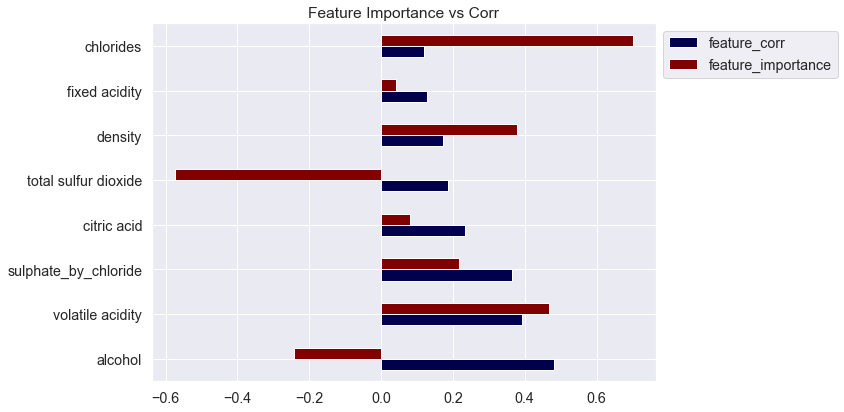

In [967]:
# Visualize feature correlations and importance

features_df.plot(kind="barh",title="Feature Importance vs Corr", legend=True, label=True, figsize=(12,6), colormap=seismic)
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig("importance_vs_corr.png", dpi=400)

As we can see atributes with highest feature importance are chlorides and total sulfur dioxide. These results show that the features with high correlation with the target actually do not have the highest feature importance.